In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN, inference_time

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100

#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
input_shape = (batch_size, 1, 28, 28)
num_labels = 10

In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels=num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 16, 14, 14]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 14, 14]         32
│    └─Tanh: 2-7                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-8                    [100, 16, 7, 7]           --
│    └─Flatten: 2-9                      [100, 784]                --
│    └─Linear: 2-10                      [100, 120]                94,200
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [6]:
PATH = "models/LeNet/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [23]:
print(inference_time(LeNN,test_dataloader, device)[1]*1e-9)

1.3232514080000002


In [13]:
criterion = CrossEntropyLoss()

train_NN(LeNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0)

[1,   100] train_loss: 0.953
test_loss: 0.497, test_accuracy: 85.78
[1,   200] train_loss: 0.366
test_loss: 0.253, test_accuracy: 92.48
[1,   300] train_loss: 0.234
test_loss: 0.180, test_accuracy: 94.5
[1,   400] train_loss: 0.186
test_loss: 0.151, test_accuracy: 95.38
[1,   500] train_loss: 0.152
test_loss: 0.140, test_accuracy: 95.53
[1,   600] train_loss: 0.140
test_loss: 0.114, test_accuracy: 96.61
[2,   100] train_loss: 0.108
test_loss: 0.118, test_accuracy: 96.58
[2,   200] train_loss: 0.099
test_loss: 0.099, test_accuracy: 96.93
[2,   300] train_loss: 0.111
test_loss: 0.088, test_accuracy: 97.31
[2,   400] train_loss: 0.092
test_loss: 0.086, test_accuracy: 97.25
[2,   500] train_loss: 0.085
test_loss: 0.083, test_accuracy: 97.77
[2,   600] train_loss: 0.070
test_loss: 0.075, test_accuracy: 97.64
[3,   100] train_loss: 0.063
test_loss: 0.067, test_accuracy: 98.07
[3,   200] train_loss: 0.053
test_loss: 0.069, test_accuracy: 97.96
[3,   300] train_loss: 0.060
test_loss: 0.070, te

In [14]:
torch.save(LeNN, "./models/LeNet/LeNet.pth")

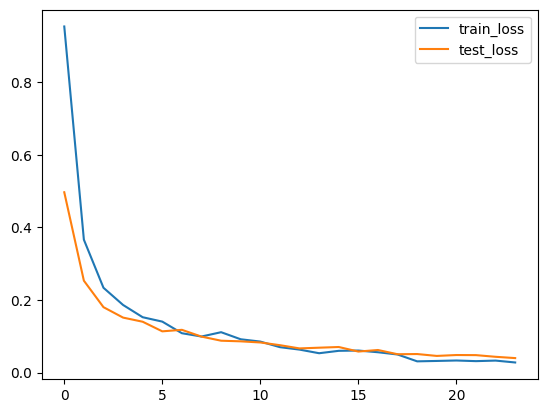

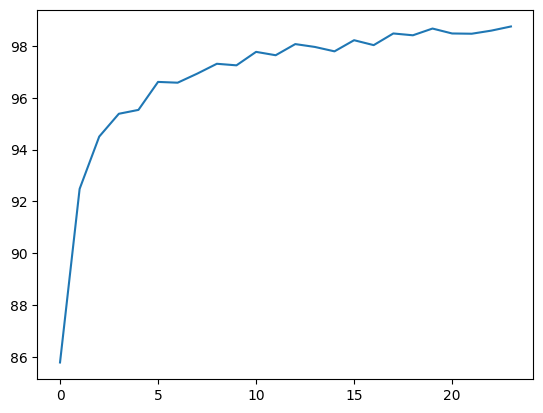

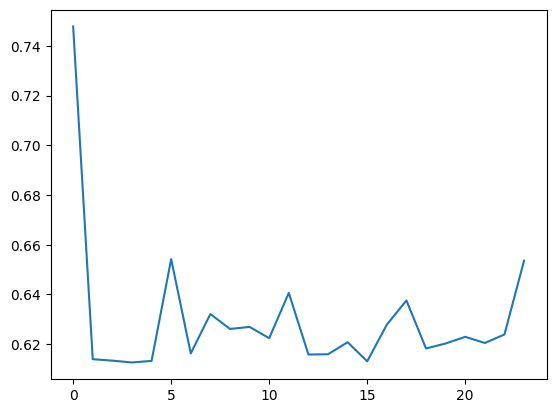

In [15]:
plt.plot(LeNN.train_loss, label="train_loss")
plt.plot(LeNN.test_loss, label = "test_loss")
plt.legend()
plt.show()
plt.plot(LeNN.test_accuracy)
plt.show()
plt.plot(LeNN.train_time)
plt.show()

In [8]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [9]:
PATH = "models/LeNet/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [25]:
print(inference_time(LeASLNN,test_dataloader, device)[1]*1e-9)

1.312007203


In [24]:
criterion = CrossEntropyLoss()

train_NN(LeASLNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0)

[1,   100] train_loss: 1.175
test_loss: 0.441, test_accuracy: 88.2
[1,   200] train_loss: 0.343
test_loss: 0.273, test_accuracy: 91.24
[1,   300] train_loss: 0.248
test_loss: 0.210, test_accuracy: 93.07
[1,   400] train_loss: 0.230
test_loss: 0.211, test_accuracy: 93.61
[1,   500] train_loss: 0.228
test_loss: 0.172, test_accuracy: 95.02
[1,   600] train_loss: 0.186
test_loss: 0.144, test_accuracy: 95.63
[2,   100] train_loss: 0.143
test_loss: 0.145, test_accuracy: 95.87
[2,   200] train_loss: 0.140
test_loss: 0.124, test_accuracy: 96.32
[2,   300] train_loss: 0.129
test_loss: 0.115, test_accuracy: 96.47
[2,   400] train_loss: 0.134
test_loss: 0.121, test_accuracy: 96.2
[2,   500] train_loss: 0.121
test_loss: 0.098, test_accuracy: 97.03
[2,   600] train_loss: 0.106
test_loss: 0.102, test_accuracy: 96.81
[3,   100] train_loss: 0.091
test_loss: 0.088, test_accuracy: 97.29
[3,   200] train_loss: 0.094
test_loss: 0.092, test_accuracy: 97.36
[3,   300] train_loss: 0.082
test_loss: 0.085, tes

In [21]:
torch.save(LeASLNN, "./models/LeNet/LeASLNet.pth")

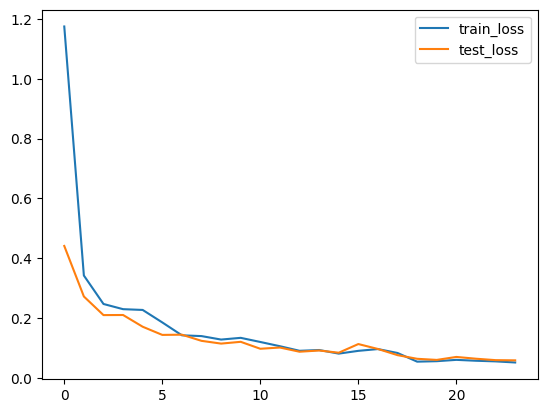

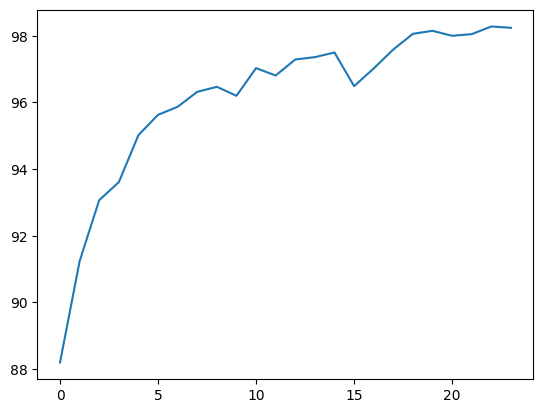

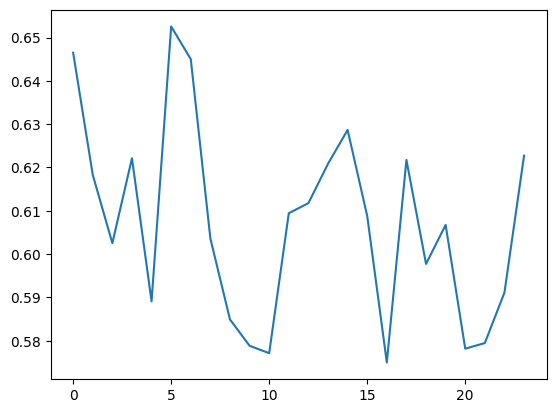

In [25]:
plt.plot(LeASLNN.train_loss, label="train_loss")
plt.plot(LeASLNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeASLNN.test_accuracy)
plt.show()
plt.plot(LeASLNN.train_time)
plt.show()

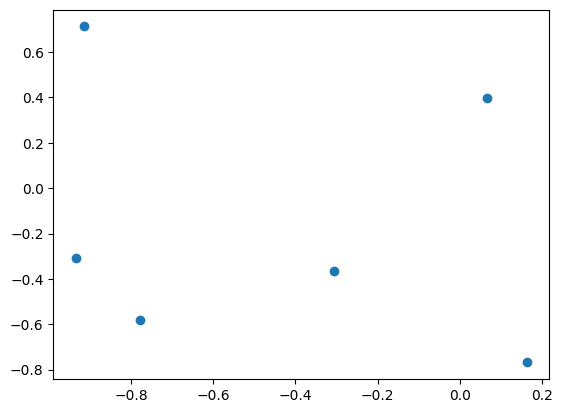

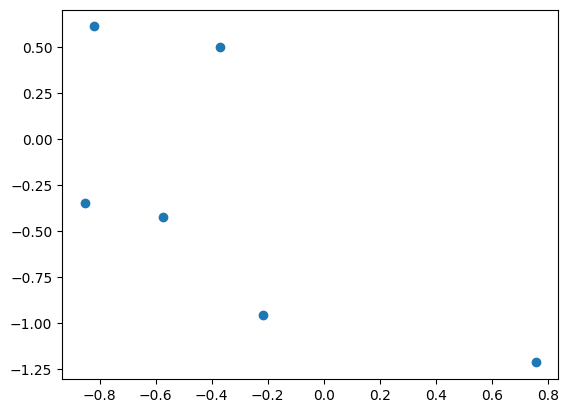

In [10]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [9]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=0.01, momentum=0.99, weight_decay=0, device=device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [10]:
PATH = "models/LeNet/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [15]:
criterion = CrossEntropyLoss()

train_NN(LeDepthNN, criterion, train_dataloader,
        test_dataloader, epochs=4, batches_to_test=100,patience=2,device=device, print_test=True, verbose=True, p_randomTransform=0)

[1,   100] train_loss: 0.036
test_loss: 0.047, test_accuracy: 98.46
[1,   200] train_loss: 0.034
test_loss: 0.048, test_accuracy: 98.42
[1,   300] train_loss: 0.032
test_loss: 0.049, test_accuracy: 98.44
[1,   400] train_loss: 0.040
test_loss: 0.050, test_accuracy: 98.42
[1,   500] train_loss: 0.039
test_loss: 0.050, test_accuracy: 98.38
Epoch 00006: reducing learning rate of group 0 to 1.2500e-03.
[1,   600] train_loss: 0.037
test_loss: 0.046, test_accuracy: 98.53
[2,   100] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.59
[2,   200] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.56
[2,   300] train_loss: 0.030
test_loss: 0.045, test_accuracy: 98.57
Epoch 00010: reducing learning rate of group 0 to 6.2500e-04.
[2,   400] train_loss: 0.031
test_loss: 0.045, test_accuracy: 98.57
[2,   500] train_loss: 0.028
test_loss: 0.045, test_accuracy: 98.58
[2,   600] train_loss: 0.027
test_loss: 0.044, test_accuracy: 98.62
[3,   100] train_loss: 0.029
test_loss: 0.045, test_accuracy

In [16]:
torch.save(LeDepthNN, "./models/LeNet/LeDepthNet.pth")

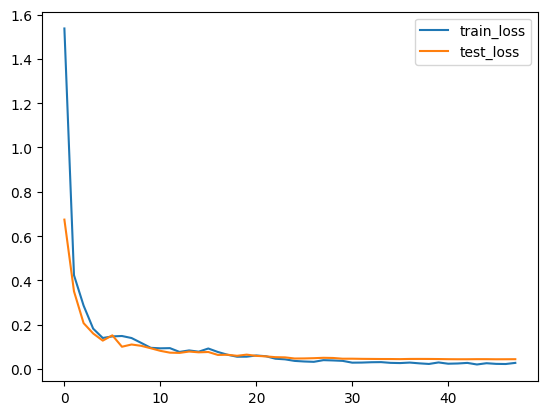

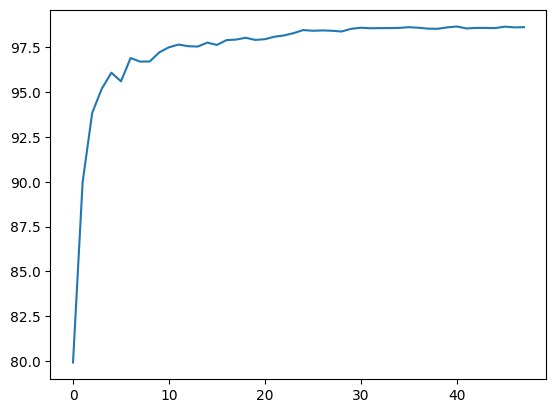

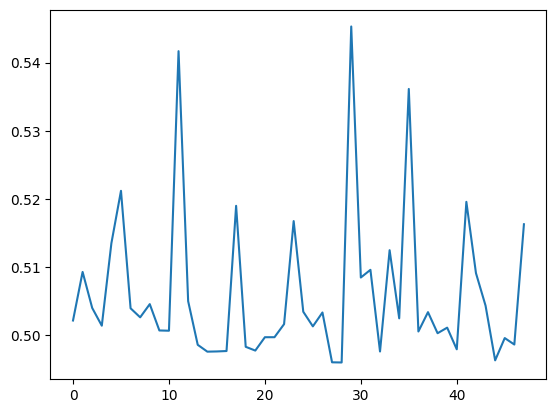

In [17]:
plt.plot(LeDepthNN.train_loss, label="train_loss")
plt.plot(LeDepthNN.test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(LeDepthNN.test_accuracy)
plt.show()
plt.plot(LeDepthNN.train_time)
plt.show()